In [1]:
import multiprocessing as mp
from tqdm.auto import tqdm
import scipy.optimize
import espargos_0007
import cluster_utils
import numpy as np
import os

2025-04-10 14:06:06.979822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 14:06:07.000857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 14:06:07.007738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 14:06:07.023612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 14:06:07.925177: W tensorflow/compiler/tf2

### Load Datasets and AoA Estimates

We only want to evaluate the triangulation performance of the test sets in this notebook.
But since we also need the triangulated groundtruth positions of the training sets in the next notebook, we will calculate them here as well.

In [2]:
# Loading all the datasets can take some time...
training_set_robot = espargos_0007.load_dataset(espargos_0007.TRAINING_SET_ROBOT_FILES)
test_set_robot = espargos_0007.load_dataset(espargos_0007.TEST_SET_ROBOT_FILES)
test_set_human = espargos_0007.load_dataset(espargos_0007.TEST_SET_HUMAN_FILES)

all_datasets = training_set_robot + test_set_robot + test_set_human

  0%|          | 0/3 [00:00<?, ?it/s]

Loading espargos-0007/espargos-0007-meanders-nw-se-1.tfrecords


I0000 00:00:1744293975.192596   29964 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744293975.251689   29964 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744293975.252086   29964 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744293975.255238   29964 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Loading espargos-0007/espargos-0007-meanders-sw-ne-1.tfrecords


2025-04-10 14:06:38.505387: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loading espargos-0007/espargos-0007-randomwalk-1.tfrecords


  0%|          | 0/1 [00:00<?, ?it/s]

Loading espargos-0007/espargos-0007-randomwalk-2.tfrecords


2025-04-10 14:06:53.418952: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/1 [00:00<?, ?it/s]

Loading espargos-0007/espargos-0007-human-helmet-randomwalk-1.tfrecords


In [3]:
for dataset in all_datasets:
    dataset_name = os.path.basename(dataset["filename"])
    dataset["cluster_aoa_angles"] = np.load(os.path.join("aoa_estimates", dataset_name + ".aoa_angles.npy"))
    dataset["cluster_aoa_powers"] = np.load(os.path.join("aoa_estimates", dataset_name + ".aoa_powers.npy"))

In [4]:
for dataset in all_datasets:
    cluster_utils.cluster_dataset(dataset)

Clustering dataset espargos-0007/espargos-0007-meanders-nw-se-1.tfrecords


  0%|          | 0/174647 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-meanders-sw-ne-1.tfrecords


  0%|          | 0/204711 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-randomwalk-1.tfrecords


  0%|          | 0/103524 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-randomwalk-2.tfrecords


  0%|          | 0/139427 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-human-helmet-randomwalk-1.tfrecords


  0%|          | 0/33011 [00:00<?, ?it/s]

### Perform Triangulation (Maximum Likelihood Approach)

In [5]:
# Heuristic: Uncertainty about angle of arrival as a function of root-MUSIC AoA estimate power
def aoa_power_to_kappa(aoa_power):
    return 5 * aoa_power**6

In [6]:
def get_likelihood_function(aoa_datapoint, aoa_power_datapoint):
    def likelihood_func(pos):
        # "relative" has shape (number of positions, number of arrays, 3 spatial dimensions)
        relative_pos = pos[:,np.newaxis,:] - espargos_0007.array_positions

        # Compute ideal AoAs at given positions, shape: (number of positions, number of arrays)
        normal = np.einsum("dax,ax->da", relative_pos, espargos_0007.array_normalvectors)
        right = np.einsum("dax,ax->da", relative_pos, espargos_0007.array_rightvectors)
        up = np.einsum("dax,ax->da", relative_pos, espargos_0007.array_upvectors)
        ideal_aoas = np.arctan2(right, normal)
        ideal_eles = -np.arctan2(up, normal)

        # Compute AoA likelihoods based on von Mises distribution
        kappas = aoa_power_to_kappa(aoa_power_datapoint)
        aoa_likelihoods = np.exp(kappas * np.cos(ideal_aoas - aoa_datapoint)) / (2 * np.pi * np.i0(kappas))

        return np.prod(aoa_likelihoods, axis = -1)

    return likelihood_func

In [7]:
for dataset in tqdm(all_datasets):
    # Height of TX is assumed to be known
    HEIGHT = np.mean(dataset["groundtruth_positions"][:,2])
    TOTAL_CLUSTERS = dataset["cluster_aoa_angles"].shape[0]

    # Generate grid of potential TX positions, used for initializing optimization algorithm
    candidate_xrange = np.linspace(np.min(espargos_0007.array_positions[:,0]) - 1, np.max(espargos_0007.array_positions[:,0]) + 1, 100)
    candidate_yrange = np.linspace(np.min(espargos_0007.array_positions[:,1]) - 1, np.max(espargos_0007.array_positions[:,1]) + 1, 100)
    candidate_initial_positions = np.transpose(np.meshgrid(candidate_xrange, candidate_yrange, HEIGHT)).reshape(-1, 3)
    
    def aoa_estimation_worker(todo_queue, output_queue):
        def estimate_position_aoa(index):
            aoa_datapoint = dataset["cluster_aoa_angles"][index]
            aoa_power_datapoint = dataset["cluster_aoa_powers"][index]
    
            # We use the TDoA-based likelihood function to get a rough initial estimate, then the ToA-based likelihood function for optimization
            likelihood_func = get_likelihood_function(aoa_datapoint, aoa_power_datapoint)
    
            # Find most likely initialization position based on AoA
            initial_point = candidate_initial_positions[np.argmax(likelihood_func(candidate_initial_positions))]
    
            # Use scipy.optimize to find most likely TX position
            init_value = np.asarray([initial_point[0], initial_point[1]])
            optimize_res = scipy.optimize.minimize(lambda pos : -likelihood_func(np.asarray([[pos[0], pos[1], HEIGHT]])), init_value, options = {"gtol": 1e-7})
    
            return np.asarray([optimize_res.x[0], optimize_res.x[1]]), -optimize_res.fun
        
        while True:
            index = todo_queue.get()
    
            if index == -1:
                output_queue.put((-1, None, None))
                break
    
            position, likelihood = estimate_position_aoa(index)
            output_queue.put((index, position, likelihood))

    todo_queue = mp.Queue()
    output_queue = mp.Queue()
    
    for i in zip(range(TOTAL_CLUSTERS)):
        todo_queue.put(i)
    
    for i in range(mp.cpu_count()):
        todo_queue.put(-1)
        p = mp.Process(target = aoa_estimation_worker, args = (todo_queue, output_queue))
        p.start()
    
    dataset["triangulation_position_estimates"] = np.zeros((TOTAL_CLUSTERS, 2))
    
    with tqdm(total = TOTAL_CLUSTERS) as bar:
        finished_processes = 0
        while finished_processes != mp.cpu_count():
            i, pos, lik = output_queue.get()

            if i == -1:
                finished_processes = finished_processes + 1
            else:
                dataset["triangulation_position_estimates"][i,:] = pos
                bar.update(1)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2860 [00:00<?, ?it/s]

  0%|          | 0/3468 [00:00<?, ?it/s]

  0%|          | 0/1684 [00:00<?, ?it/s]

  0%|          | 0/2337 [00:00<?, ?it/s]

  0%|          | 0/556 [00:00<?, ?it/s]

### Store Triangulation Results to File

In [8]:
!mkdir -p triangulation_estimates
for dataset in all_datasets:
    np.save(os.path.join("triangulation_estimates", os.path.basename(dataset["filename"])) + ".npy", dataset["triangulation_position_estimates"])

### Optional: Plot Triangulation Results

In [9]:
import CCEvaluation

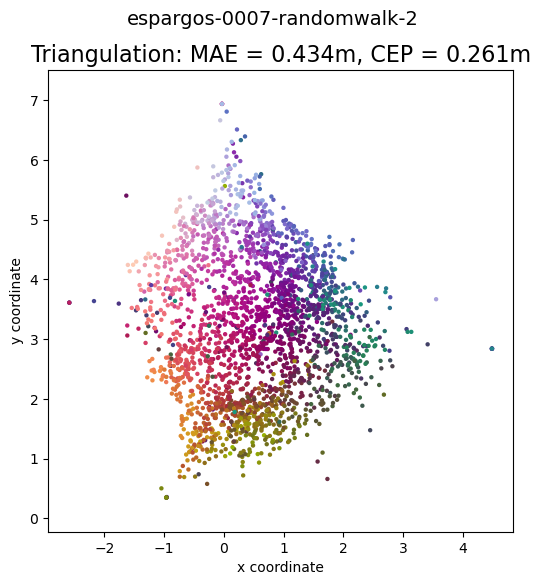

Evaluation for espargos-0007/espargos-0007-randomwalk-2.tfrecords
   MAE: 0.434
  DRMS: 0.694
   CEP: 0.261
   R95: 1.368
    KS: 0.273
    CT: 0.927
    TW: 0.922


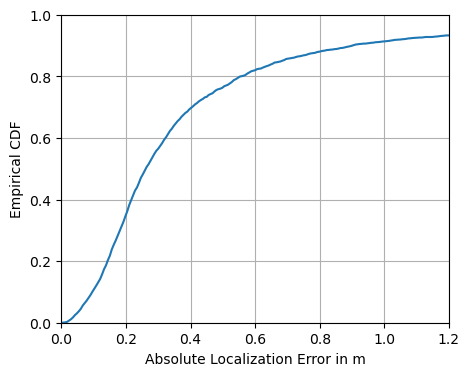

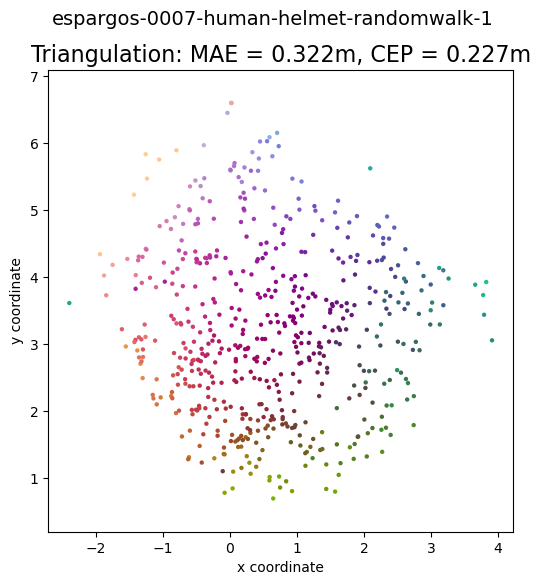

Evaluation for espargos-0007/espargos-0007-human-helmet-randomwalk-1.tfrecords
   MAE: 0.322
  DRMS: 0.499
   CEP: 0.227
   R95: 0.775
    KS: 0.123
    CT: 0.989
    TW: 0.988


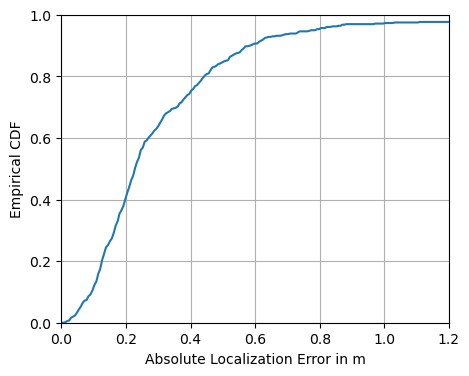

In [10]:
for dataset in (test_set_robot + test_set_human):
    errorvectors, errors, mae, cep = CCEvaluation.compute_localization_metrics(dataset["triangulation_position_estimates"][:,:2], dataset["cluster_positions"][:,:2])
    suptitle = f"{os.path.splitext(os.path.basename(dataset["filename"]))[0]}"
    title = f"Triangulation: MAE = {mae:.3f}m, CEP = {cep:.3f}m"
    CCEvaluation.plot_colorized(dataset["triangulation_position_estimates"][:,:2], dataset["cluster_positions"][:,:2], suptitle = suptitle, title = title)
    metrics = CCEvaluation.compute_all_performance_metrics(dataset["triangulation_position_estimates"][:,:2], dataset["cluster_positions"][:,:2])
    CCEvaluation.plot_error_ecdf(dataset["triangulation_position_estimates"][:,:2], dataset["cluster_positions"][:,:2])
    print(f"Evaluation for {dataset["filename"]}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name.upper().rjust(6, " ")}: {metric_value:.3f}")